In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pyXRD import pyXRDCodes
from scipy.signal import find_peaks
from scipy.optimize import minimize
from matplotlib.gridspec import GridSpec
from typing import List, Tuple, Optional

# O que queremos lidar com aqui

In [15]:
class Cell:
    def __init__(self, 
                 unit_params: List[float], 
                 unit_angles: List[float], 
                 lamb: float, 
                 structure: str = 'orthorhombic',
                 param_step: float = 0.01,
                 angle_step: float = 0.1,
                 bounds_param: List[float] = [1, 20],
                 bounds_angle: List[float] = [50, 125],
                 structures: List[str] = ['cubic', 'hexagonal', 'tetragonal', 
                                         'orthorhombic', 'monoclinic', 'trigonal', 'triclinic']):
        """
        Initialize a unit cell with given parameters and constraints.
        
        Args:
            unit_params: List of lattice parameters [a, b, c]
            unit_angles: List of lattice angles [α, β, γ] in degrees
            lamb: Wavelength for diffraction calculations
            structure: Crystal system (must be in structures list)
            param_step: Step size for lattice parameter mutations
            angle_step: Step size for angle mutations
            bounds_param: [min, max] bounds for lattice parameters
            bounds_angle: [min, max] bounds for angles
            structures: List of allowed crystal systems
        """
        # Validate inputs
        if len(unit_params) != 3 or len(unit_angles) != 3:
            raise ValueError("Both unit_params and unit_angles must have length 3")
            
        if structure not in structures:
            raise ValueError(f"Structure must be one of: {structures}")
            
        if bounds_param[0] >= bounds_param[1] or bounds_angle[0] >= bounds_angle[1]:
            raise ValueError("Bounds must be in format [min, max] with min < max")
            
        # Initialize grids and validate parameters
        self.param_grid = np.arange(bounds_param[0], bounds_param[1], param_step)
        self.angle_grid = np.arange(bounds_angle[0], bounds_angle[1], angle_step)
        
        # Initialize properties
        self.unit_params = np.clip(np.array(unit_params, dtype=float), 
                                  bounds_param[0], bounds_param[1])
        self.unit_angles = np.clip(np.array(unit_angles, dtype=float), 
                                bounds_angle[0], bounds_angle[1])
        self.lamb = float(lamb)
        self.structure = structure
        self.structures = structures
        self.param_step = float(param_step)
        self.angle_step = float(angle_step)
        self.bounds_param = bounds_param
        self.bounds_angle = bounds_angle
        
        # Enforce structure constraints
        self._enforce_structure_constraints()
        self._validate_parameters()

    def _validate_parameters(self) -> None:
        """Ensure all parameters are within bounds and follow structure rules"""
        # Clip values to bounds
        self.unit_params = np.clip(self.unit_params, 
                                  self.bounds_param[0], self.bounds_param[1])
        self.unit_angles = np.clip(self.unit_angles, 
                                  self.bounds_angle[0], self.bounds_angle[1])
        
        # Round to nearest grid point
        for i in range(3):
            idx = np.abs(self.param_grid - self.unit_params[i]).argmin()
            self.unit_params[i] = self.param_grid[idx]
            
            idx = np.abs(self.angle_grid - self.unit_angles[i]).argmin()
            self.unit_angles[i] = self.angle_grid[idx]

    def _enforce_structure_constraints(self) -> None:
        """Enforce constraints based on crystal system"""
        # First clip all values to their grids
        self._validate_parameters()
        
        # Structure-specific constraints
        if self.structure == 'cubic':
            avg = np.round(np.mean(self.unit_params[:3]), 1)
            self.unit_params = np.array([avg]*3)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'tetragonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 1)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'orthorhombic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'monoclinic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure β angle is not 90° and different from others
            if abs(self.unit_angles[1] - 90) < self.angle_step:
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    self.unit_angles[1] = np.random.choice(valid)
            self.unit_angles[0] = 90
            self.unit_angles[2] = 90
            
        elif self.structure == 'hexagonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 1)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 120], dtype=float)
            
        elif self.structure == 'trigonal':
            avg = np.round(np.mean(self.unit_params[:3]), 1)
            self.unit_params = np.array([avg]*3)
            
            # For angles, either all 90° or all equal non-90°
            if all(abs(a - 90) < self.angle_step for a in self.unit_angles):
                # Change to non-90° angles
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    angle = np.random.choice(valid)
                    self.unit_angles = np.array([angle]*3)
            else:
                # Make all angles equal
                avg_angle = np.round(np.mean(self.unit_angles), 1)
                self.unit_angles = np.array([avg_angle]*3)
                
        elif self.structure == 'triclinic':
            # Ensure all parameters and angles are different
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure angles are different and not 90°
            for i in range(3):
                if abs(self.unit_angles[i] - 90) < self.angle_step:
                    valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                    if len(valid) > 0:
                        self.unit_angles[i] = np.random.choice(valid)
            
            # Ensure all angles are different
            if len(set(np.round(self.unit_angles/self.angle_step))) < 3:
                angles = []
                available = list(self.angle_grid[abs(self.angle_grid - 90) > self.angle_step])
                for i in range(3):
                    if available:
                        angle = np.random.choice(available)
                        angles.append(angle)
                        available.remove(angle)
                    else:
                        angles.append(90 + (i+1)*10)  # Fallback
                self.unit_angles = np.array(angles)
        
        # Final validation
        self._validate_parameters()

    def give_theta2(self) -> np.ndarray:
        """Calculate 2θ angles for the current cell"""
        _, _, calculated_theta, _ = pyXRDCodes.generate_hkls(
            self.lamb, 10, self.unit_params, self.unit_angles
        )
        return np.round(2*np.array(calculated_theta), 2) if len(calculated_theta) > 0 else np.array([])

    def mutate(self, 
              change_prob: float = 0.5,
              struct_change_prob: float = 0.1,
              change_shuffle:float =0.05,
              min_step_param: int = 1,
              max_step_param: int = 40,
              min_step_angle: int = 1,
              max_step_angle: int = 50) -> None:
        """
        Adaptive mutation with parameter and structure changes.
        
        Args:
            change_prob: Probability of changing a parameter
            min_step_param: Minimum mutation steps for parameters
            max_step_param: Maximum mutation steps for parameters
            min_step_angle: Minimum mutation steps for angles
            max_step_angle: Maximum mutation steps for angles
            struct_change_prob: Probability of changing crystal structure
        """
        # Parameter mutations
        for i in range(3):
            if random.random() < change_prob:
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_param, max_step_param)
                idx = np.where(np.isclose(self.param_grid, self.unit_params[i]))[0][0]
                new_idx = max(0, min(len(self.param_grid)-1, idx + step))
                self.unit_params[i] = self.param_grid[new_idx]
                
            if random.random() < change_prob:
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_angle, max_step_angle)
                idx = np.where(np.isclose(self.angle_grid, self.unit_angles[i]))[0][0]
                new_idx = max(0, min(len(self.angle_grid)-1, idx + step))
                self.unit_angles[i] = self.angle_grid[new_idx]
        
        # Structure mutation
        if random.random() < struct_change_prob and len(self.structures) > 1:
            self.structure = random.choice([s for s in self.structures if s != self.structure])
        
        if random.random() <change_shuffle:
            self.unit_angles = random.sample(list(self.unit_angles),3)
            self.unit_params = random.sample(list(self.unit_params),3)
        
        # Enforce constraints
        self._enforce_structure_constraints()

    def crossover(self, other, inherit_prob: float = 0.7) -> 'Cell':
        """Blend two cells to create a new child cell"""
        child = self.copy()
        
        for i in range(3):
            #if random.random() > inherit_prob:
            child.unit_params[i] = other.unit_params[i]*(1-inherit_prob) + self.unit_params[i]*inherit_prob
            #if random.random() > inherit_prob:
            child.unit_angles[i] = other.unit_angles[i]*(1-inherit_prob) + self.unit_angles[i]*inherit_prob
        
        if random.random() > inherit_prob:
            child.structure = other.structure
        
        child._enforce_structure_constraints()
        return child

    def copy(self) -> 'Cell':
        """Create a deep copy of the cell"""
        return Cell(
            self.unit_params.copy(), 
            self.unit_angles.copy(), 
            self.lamb, 
            self.structure,
            self.param_step,
            self.angle_step,
            self.bounds_param,
            self.bounds_angle,
            self.structures.copy()
        )

    def print_(self) -> str:
        return (f"Cell(a={self.unit_params[0]:.2f}, b={self.unit_params[1]:.2f}, c={self.unit_params[2]:.2f}, "
               f"α={self.unit_angles[0]:.1f}°, β={self.unit_angles[1]:.1f}°, γ={self.unit_angles[2]:.1f}°, "
               f"structure='{self.structure}')")

In [155]:
def Vol_calc(unit_params,unit_angles,V_max):
    a = pyXRDCodes.abcToxyz([1,0,0],unit_params,unit_angles)
    b = pyXRDCodes.abcToxyz([0,1,0],unit_params,unit_angles)
    c = pyXRDCodes.abcToxyz([0,0,1],unit_params,unit_angles)
    V = abs(np.dot(a,np.cross(b,c)))
    
    if V>=V_max:
        return False
    return True


def cosine_fitness(cell, theta2_exp, power=1, peak_tol=0.02,v_max=3000):
    """
    Cosine similarity-based fitness with power scaling for peak matching
    
    Args:
        struct: Candidate structure
        theta2_exp: Experimental 2θ angles (degrees)
        int_exp: Experimental intensities
        lamb: Wavelength (Å)
        alltheta2: All possible theoretical 2θ angles
        power: Exponent for cosine similarity (higher = stricter)
        peak_tol: Peak matching tolerance (degrees)
        
    Returns:
        Fitness score (higher is better)
    """
    if not(Vol_calc(cell.unit_params,cell.unit_angles,v_max)):
        return 1e3
    # Calculate theoretical pattern
    alltheta2 = np.arange(min(theta2_exp)-2 , max(theta2_exp)+2,peak_tol)
    thetas2 = np.array(cell.give_theta2())

    mask = (thetas2>=min(alltheta2)-2)&(thetas2<=max(alltheta2)+2)
    thetas2 = thetas2[mask]
    if len(thetas2)==0:
        return 1e3

    # Create binary peak vectors (1=peak, 0=no peak)
    def make_binary_vector(peaks_theta):
        vec = np.zeros(len(alltheta2))
        for t in peaks_theta:
            idx = np.argmin(np.abs(alltheta2 - t))
            #if np.abs(alltheta2[idx] - t) <= peak_tol:
            vec[idx] = 1
        return vec
    
    # Experimental binary vector (only peaks above threshold)
    v = make_binary_vector(theta2_exp)
    u = make_binary_vector(thetas2)
    
    # Calculate cosine similarity
    dot_product = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    # Handle edge cases
    if norm_u == 0 or norm_v == 0:
        return 1e3
    
    cosine_sim = dot_product / (norm_u * norm_v)
    
    # Apply power scaling
    fitness = (cosine_sim)**power

    return -fitness #- atom_penalty  # Higher is better




In [156]:
lamb = 1.5406
target_Atoms = ['Ti', 'C', 'O']

structures=['cubic','hexagonal','tetragonal','orthorhombic','monoclinic','trigonal','triclinic']



target_structure = ['cubic','hexagonal','tetragonal','orthorhombic','monoclinic','trigonal','triclinic']
giving_params = [[5,5,5],[3,3,15],[4,4,20],[5.2,7.8,15],[8,4,6],[7,7,7],[5,12,8]]
giving_angles = [[90,90,90],[90,90,120],[90,90,90],[90,90,90],[90,115,90],[70,70,70],[65,80,110]]


-0.5525062514530824
-0.500543419353953
-0.3826918985879519


Text(0.5, 0, ' 2$\\theta$ (degrees)')

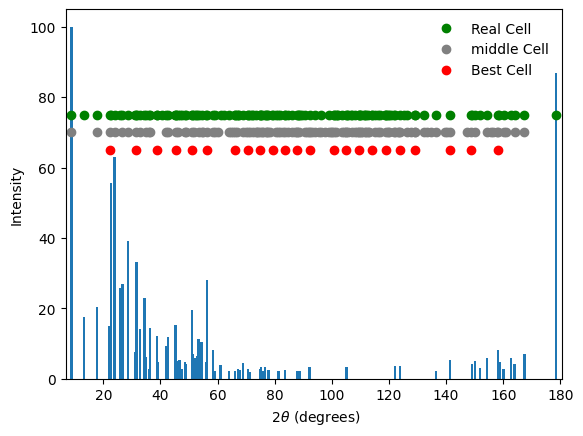

In [157]:
targe_unit_params = np.array(giving_params[2]) 
targe_unit_angles = np.array(giving_angles[2]) 
target_Positions = [
                        [pyXRDCodes.abcToxyz([1/2, 1/3, 1/3], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 0, 0], targe_unit_params, targe_unit_angles),
                        pyXRDCodes.abcToxyz([1/2, 1/2, 1/2], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 1/2, 1/2], targe_unit_params, targe_unit_angles)]
]
# Run GA
# Generate expected peaks
data = pyXRDCodes.simulate_xrd(lamb, 10, targe_unit_params, targe_unit_angles, target_Positions, target_Atoms)
observed_theta = np.round(np.array(data['two_thetas']), 2)
U = data['intensities']
plt.bar(observed_theta,U)

real = Cell(np.array(giving_params[2]),np.array(giving_angles[2]),lamb,target_structure[2])
print(cosine_fitness(real,observed_theta,1,0.02,3000))
_,_,theta2real,_ = pyXRDCodes.generate_hkls(lamb,10,np.array(giving_params[2]),np.array(giving_angles[2]))
theta2real = 2 *np.array(theta2real)
plt.plot(theta2real , np.ones(len(theta2real))*75,'o',color='green' , label='Real Cell')

middle = Cell(np.array([4,4,10]),np.array([90,90,90]),lamb,'tetragonal')
print(cosine_fitness(middle,observed_theta,1,0.02,3000))
theta22 = np.array(middle.give_theta2())
plt.plot(theta22 , np.ones(len(theta22))*70,'o' ,color='gray', label='middle Cell')


best = Cell(np.array([4,4,4]),np.array([90,90,90]),lamb,'cubic')
print(cosine_fitness(best,observed_theta,1,0.02,3000))
theta2 = np.array(best.give_theta2())
plt.plot(theta2 , np.ones(len(theta2))*65,'o' ,color='red', label='Best Cell')

plt.xlim(min(observed_theta)-2,max(observed_theta)+2)
plt.legend(frameon=False)
plt.ylabel('Intensity')
plt.xlabel(r' 2$\theta$ (degrees)')

-0.6324555320336759
-0.5477225575051661
-0.5477225575051661


Text(0.5, 0, ' 2$\\theta$ (degrees)')

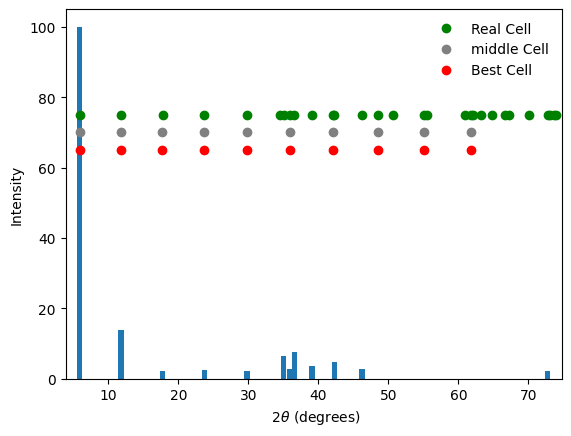

In [159]:
targe_unit_params = np.array(giving_params[1]) 
targe_unit_angles = np.array(giving_angles[1]) 
target_Positions = [
                        [pyXRDCodes.abcToxyz([1/2, 1/3, 1/3], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 0, 0], targe_unit_params, targe_unit_angles),
                        pyXRDCodes.abcToxyz([1/2, 1/2, 1/2], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 1/2, 1/2], targe_unit_params, targe_unit_angles)]
]
# Run GA
# Generate expected peaks
data = pyXRDCodes.simulate_xrd(lamb, 10, targe_unit_params, targe_unit_angles, target_Positions, target_Atoms)
observed_theta = np.round(np.array(data['two_thetas']), 2)
U = data['intensities']
plt.bar(observed_theta,U)


real = Cell(np.array(giving_params[1]),np.array(giving_angles[1]),lamb,target_structure[1])
print(cosine_fitness(real,observed_theta,1,0.02,3000))
_,_,theta2real,_ = pyXRDCodes.generate_hkls(lamb,10,np.array(giving_params[1]),np.array(giving_angles[1]))
theta2real = 2 *np.array(theta2real)
plt.plot(theta2real , np.ones(len(theta2real))*75,'o',color='green' , label='Real Cell')


middle = Cell(np.array([1,1,15]),np.array([90,90,120]),lamb,'hexagonal')
print(cosine_fitness(middle,observed_theta,1,0.02,3000))
theta2 = np.array(middle.give_theta2())
plt.plot(theta2 , np.ones(len(theta2))*70,'o' ,color='gray', label='middle Cell')

best = Cell(np.array([1,1,15]),np.array([90,90,90]),lamb,'tetragonal')
print(cosine_fitness(best,observed_theta,1,0.02,3000))
theta2 = np.array(best.give_theta2())
plt.plot(theta2 , np.ones(len(theta2))*65,'o' ,color='red', label='Best Cell')

plt.xlim(min(observed_theta)-2,max(observed_theta)+2)
plt.legend(frameon=False)
plt.ylabel('Intensity')
plt.xlabel(r' 2$\theta$ (degrees)')

---

---

# Mostrar o que queremos fazer de minimizar

In [2]:
class Cell:
    def __init__(self, 
                 unit_params: List[float], 
                 unit_angles: List[float], 
                 lamb: float, 
                 structure: str = 'orthorhombic',
                 param_step: float = 0.01,
                 angle_step: float = 0.1,
                 bounds_param: List[float] = [1, 20],
                 bounds_angle: List[float] = [50, 125],
                 structures: List[str] = ['cubic', 'hexagonal', 'tetragonal', 
                                         'orthorhombic', 'monoclinic', 'trigonal', 'triclinic']):
        """
        Initialize a unit cell with given parameters and constraints.
        
        Args:
            unit_params: List of lattice parameters [a, b, c]
            unit_angles: List of lattice angles [α, β, γ] in degrees
            lamb: Wavelength for diffraction calculations
            structure: Crystal system (must be in structures list)
            param_step: Step size for lattice parameter mutations
            angle_step: Step size for angle mutations
            bounds_param: [min, max] bounds for lattice parameters
            bounds_angle: [min, max] bounds for angles
            structures: List of allowed crystal systems
        """
        # Validate inputs
        if len(unit_params) != 3 or len(unit_angles) != 3:
            raise ValueError("Both unit_params and unit_angles must have length 3")
            
        if structure not in structures:
            raise ValueError(f"Structure must be one of: {structures}")
            
        if bounds_param[0] >= bounds_param[1] or bounds_angle[0] >= bounds_angle[1]:
            raise ValueError("Bounds must be in format [min, max] with min < max")
            
        # Initialize grids and validate parameters
        self.param_grid = np.arange(bounds_param[0], bounds_param[1], param_step)
        self.angle_grid = np.arange(bounds_angle[0], bounds_angle[1], angle_step)
        
        # Initialize properties
        self.unit_params = np.clip(np.array(unit_params, dtype=float), 
                                  bounds_param[0], bounds_param[1])
        self.unit_angles = np.clip(np.array(unit_angles, dtype=float), 
                                bounds_angle[0], bounds_angle[1])
        self.lamb = float(lamb)
        self.structure = structure
        self.structures = structures
        self.param_step = float(param_step)
        self.angle_step = float(angle_step)
        self.bounds_param = bounds_param
        self.bounds_angle = bounds_angle
        
        # Enforce structure constraints
        self._enforce_structure_constraints()
        self._validate_parameters()

    def _validate_parameters(self) -> None:
        """Ensure all parameters are within bounds and follow structure rules"""
        # Clip values to bounds
        self.unit_params = np.clip(self.unit_params, 
                                  self.bounds_param[0], self.bounds_param[1])
        self.unit_angles = np.clip(self.unit_angles, 
                                  self.bounds_angle[0], self.bounds_angle[1])
        
        # Round to nearest grid point
        for i in range(3):
            idx = np.abs(self.param_grid - self.unit_params[i]).argmin()
            self.unit_params[i] = self.param_grid[idx]
            
            idx = np.abs(self.angle_grid - self.unit_angles[i]).argmin()
            self.unit_angles[i] = self.angle_grid[idx]

    def _enforce_structure_constraints(self) -> None:
        """Enforce constraints based on crystal system"""
        # First clip all values to their grids
        self._validate_parameters()
        
        # Structure-specific constraints
        if self.structure == 'cubic':
            avg = np.round(np.mean(self.unit_params[:3]), 1)
            self.unit_params = np.array([avg]*3)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'tetragonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 1)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'orthorhombic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'monoclinic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure β angle is not 90° and different from others
            if abs(self.unit_angles[1] - 90) < self.angle_step:
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    self.unit_angles[1] = np.random.choice(valid)
            self.unit_angles[0] = 90
            self.unit_angles[2] = 90
            
        elif self.structure == 'hexagonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 1)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 120], dtype=float)
            
        elif self.structure == 'trigonal':
            avg = np.round(np.mean(self.unit_params[:3]), 1)
            self.unit_params = np.array([avg]*3)
            
            # For angles, either all 90° or all equal non-90°
            if all(abs(a - 90) < self.angle_step for a in self.unit_angles):
                # Change to non-90° angles
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    angle = np.random.choice(valid)
                    self.unit_angles = np.array([angle]*3)
            else:
                # Make all angles equal
                avg_angle = np.round(np.mean(self.unit_angles), 1)
                self.unit_angles = np.array([avg_angle]*3)
                
        elif self.structure == 'triclinic':
            # Ensure all parameters and angles are different
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure angles are different and not 90°
            for i in range(3):
                if abs(self.unit_angles[i] - 90) < self.angle_step:
                    valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                    if len(valid) > 0:
                        self.unit_angles[i] = np.random.choice(valid)
            
            # Ensure all angles are different
            if len(set(np.round(self.unit_angles/self.angle_step))) < 3:
                angles = []
                available = list(self.angle_grid[abs(self.angle_grid - 90) > self.angle_step])
                for i in range(3):
                    if available:
                        angle = np.random.choice(available)
                        angles.append(angle)
                        available.remove(angle)
                    else:
                        angles.append(90 + (i+1)*10)  # Fallback
                self.unit_angles = np.array(angles)
        
        # Final validation
        self._validate_parameters()

    def give_theta2(self) -> np.ndarray:
        """Calculate 2θ angles for the current cell"""
        _, _, calculated_theta, _ = pyXRDCodes.generate_hkls(
            self.lamb, 10, self.unit_params, self.unit_angles
        )
        return np.round(2*np.array(calculated_theta), 2) if len(calculated_theta) > 0 else np.array([])

    def mutate(self, 
              change_prob: float = 0.5,
              struct_change_prob: float = 0.1,
              change_shuffle:float =0.05,
              min_step_param: int = 1,
              max_step_param: int = 40,
              min_step_angle: int = 1,
              max_step_angle: int = 50) -> None:
        """
        Adaptive mutation with parameter and structure changes.
        
        Args:
            change_prob: Probability of changing a parameter
            min_step_param: Minimum mutation steps for parameters
            max_step_param: Maximum mutation steps for parameters
            min_step_angle: Minimum mutation steps for angles
            max_step_angle: Maximum mutation steps for angles
            struct_change_prob: Probability of changing crystal structure
        """
        # Parameter mutations
        for i in range(3):
            if random.random() < change_prob:
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_param, max_step_param)
                idx = np.where(np.isclose(self.param_grid, self.unit_params[i]))[0][0]
                new_idx = max(0, min(len(self.param_grid)-1, idx + step))
                self.unit_params[i] = self.param_grid[new_idx]
                
            if random.random() < change_prob:
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_angle, max_step_angle)
                idx = np.where(np.isclose(self.angle_grid, self.unit_angles[i]))[0][0]
                new_idx = max(0, min(len(self.angle_grid)-1, idx + step))
                self.unit_angles[i] = self.angle_grid[new_idx]
        
        # Structure mutation
        if random.random() < struct_change_prob and len(self.structures) > 1:
            self.structure = random.choice([s for s in self.structures if s != self.structure])
        
        if random.random() <change_shuffle:
            self.shuffle_structure_constraints()
        
        # Enforce constraints
        self._enforce_structure_constraints()

    def crossover(self, other, inherit_prob: float = 0.7) -> 'Cell':
        """Blend two cells to create a new child cell"""
        child = self.copy()
        
        for i in range(3):
            #if random.random() > inherit_prob:
            child.unit_params[i] = other.unit_params[i]*(1-inherit_prob) + self.unit_params[i]*inherit_prob
            #if random.random() > inherit_prob:
            child.unit_angles[i] = other.unit_angles[i]*(1-inherit_prob) + self.unit_angles[i]*inherit_prob
        
        if random.random() > inherit_prob:
            child.structure = other.structure
        
        child._enforce_structure_constraints()
        return child

    def copy(self) -> 'Cell':
        """Create a deep copy of the cell"""
        return Cell(
            self.unit_params.copy(), 
            self.unit_angles.copy(), 
            self.lamb, 
            self.structure,
            self.param_step,
            self.angle_step,
            self.bounds_param,
            self.bounds_angle,
            self.structures.copy()
        )
    def shuffle_structure_constraints(self) -> None:
        """Shuffle parameters in a way consistent with the crystal structure."""

        if self.structure == 'tetragonal':
            ab = self.unit_params[0]
            c = self.unit_params[1]
            self.unit_params = np.array([c, c, ab])

        elif self.structure == 'orthorhombic':
            self.unit_params = np.random.choice(self.unit_params, 3, replace=False)

        elif self.structure == 'monoclinic':
            self.unit_params = np.random.choice(self.param_grid, 3, replace=False)

        elif self.structure == 'hexagonal':
            ab = self.unit_params[0]
            c = self.unit_params[1]
            self.unit_params = np.array([c, c, ab])

        elif self.structure == 'triclinic':
            self.unit_params = np.random.choice(self.unit_params, 3, replace=False)
            self.unit_angles = np.random.choice(self.unit_angles, 3, replace=False)
    def print_(self) -> str:
        return (f"Cell(a={self.unit_params[0]:.2f}, b={self.unit_params[1]:.2f}, c={self.unit_params[2]:.2f}, "
               f"α={self.unit_angles[0]:.1f}°, β={self.unit_angles[1]:.1f}°, γ={self.unit_angles[2]:.1f}°, "
               f"structure='{self.structure}')")

In [3]:
def generate_initial_cell(
    structures: List[str],
    param_step: float = 0.01,
    angle_step: float = 0.1,
    param_bounds: List[float] = [1, 20],
    angle_bounds: List[float] = [50, 124],
    min_param_diff: float = 0.5,
    min_angle_diff: float = 5.0
) -> Tuple[List[float], List[float], str]:
    """
    Generate a random unit cell configuration according to crystal system constraints.
    
    Args:
        structures: List of allowed crystal systems
        params_list: Array of possible lattice parameter values
        angles_list: Array of possible angle values
        param_bounds: [min, max] bounds for lattice parameters
        angle_bounds: [min, max] bounds for angles
        min_param_diff: Minimum difference between distinct parameters
        min_angle_diff: Minimum difference between distinct angles
        
    Returns:
        Tuple of (unit_params, unit_angles, structure)
    """
    params_list = np.arange(param_bounds[0],param_bounds[1]+param_step,param_step)
    angles_list = np.arange(angle_bounds[0],angle_bounds[1]+angle_step,angle_step)

    # Validate inputs
    if len(param_bounds) != 2 or len(angle_bounds) != 2:
        raise ValueError("Bounds must be lists of length 2")
    if param_bounds[0] >= param_bounds[1] or angle_bounds[0] >= angle_bounds[1]:
        raise ValueError("Bounds must be in format [min, max] with min < max")
    
    # Filter parameters and angles within bounds
    
    # Select random crystal structure
    structure = random.choice(structures)
    
    # Helper function to get distinct parameters
    def get_distinct_param(exclude: List[float] = []) -> float:
        """Get a parameter value distinct from excluded values"""
        valid = params_list
        for val in exclude:
            valid = valid[np.abs(valid - val) >= min_param_diff]
        if len(valid) == 0:
            # Fallback: use any parameter if no distinct ones available
            return random.choice(params_list)
        return random.choice(valid)
    
    # Helper function to get distinct angles
    def get_distinct_angle(exclude: List[float] = [], not_90: bool = False) -> float:
        """Get an angle value distinct from excluded values"""
        valid = angles_list
        if not_90:
            valid = valid[np.abs(valid - 90) >= min_angle_diff]
        for val in exclude:
            valid = valid[np.abs(valid - val) >= min_angle_diff]
        if len(valid) == 0:
            # Fallback: use any angle if no distinct ones available
            return random.choice(angles_list)
        return random.choice(valid)
    
    # Generate parameters based on crystal system
    if structure == 'cubic':
        a = random.choice(params_list)
        b, c = a, a
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'tetragonal':
        a = random.choice(params_list)
        b = a
        c = get_distinct_param([a])
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'hexagonal':
        a = random.choice(params_list)
        b = a
        c = get_distinct_param([a])
        alpha, beta = 90.0, 90.0
        gamma = 120.0
        
    elif structure == 'orthorhombic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'monoclinic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha, gamma = 90.0, 90.0
        beta = get_distinct_angle(not_90=True)
        
    elif structure == 'trigonal':
        a = random.choice(params_list)
        b, c = a, a
        angle = get_distinct_angle(not_90=True)
        alpha, beta, gamma = angle, angle, angle
        
    elif structure == 'triclinic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha = get_distinct_angle(not_90=True)
        beta = get_distinct_angle(exclude=[alpha], not_90=True)
        gamma = get_distinct_angle(exclude=[alpha, beta], not_90=True)
        
    else:
        raise ValueError(f"Unknown crystal structure: {structure}")
    
    # Round values appropriately
    unit_params = [round(a, 2), round(b, 2), round(c, 2)]
    unit_angles = [round(alpha, 1), round(beta, 1), round(gamma, 1)]
    
    return unit_params, unit_angles, structure

In [4]:
def Vol_calc(unit_params,unit_angles,V_max):
    a = pyXRDCodes.abcToxyz([1,0,0],unit_params,unit_angles)
    b = pyXRDCodes.abcToxyz([0,1,0],unit_params,unit_angles)
    c = pyXRDCodes.abcToxyz([0,0,1],unit_params,unit_angles)
    V = abs(np.dot(a,np.cross(b,c)))
    
    if V>=V_max:
        return False
    return True

Vol_calc([3,3,15],[90,90,120],2500)

True

In [5]:
def cosine_fitness(cell, theta2_exp, power=1, peak_tol=0.02,v_max=3000):
    """
    Cosine similarity-based fitness with power scaling for peak matching
    
    Args:
        struct: Candidate structure
        theta2_exp: Experimental 2θ angles (degrees)
        int_exp: Experimental intensities
        lamb: Wavelength (Å)
        alltheta2: All possible theoretical 2θ angles
        power: Exponent for cosine similarity (higher = stricter)
        peak_tol: Peak matching tolerance (degrees)
        
    Returns:
        Fitness score (higher is better)
    """
    if not(Vol_calc(cell.unit_params,cell.unit_angles,v_max)):
        return 1e3
    # Calculate theoretical pattern
    alltheta2 = np.arange(min(theta2_exp)-1 , max(theta2_exp)+1,peak_tol)
    thetas2 = np.array(cell.give_theta2())

    mask = (thetas2>=min(alltheta2))&(thetas2<=max(alltheta2))
    thetas2 = thetas2[mask]

    # Create binary peak vectors (1=peak, 0=no peak)
    def make_binary_vector(peaks_theta):
        vec = np.zeros(len(alltheta2))
        for t in peaks_theta:
            idx = np.argmin(np.abs(alltheta2 - t))
            vec[idx] = 1
        return vec
    
    # Experimental binary vector (only peaks above threshold)
    v = make_binary_vector(theta2_exp)
    u = make_binary_vector(thetas2)
    
    # Calculate cosine similarity
    dot_product = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    # Handle edge cases
    if norm_u == 0 or norm_v == 0:
        return 1e3
    
    cosine_sim = dot_product / (norm_u * norm_v)
    
    # Apply power scaling
    fitness = (cosine_sim)**power
    
    return -fitness #- atom_penalty  # Higher is better



---
Fazer Ilhas

In [8]:
def run_ga(observed_peaks, peak_tol=0.01, power=1, lamb=1.5406, generations=10, numb_pop=60,
           bounds_params=[1, 25], bounds_angles=[50, 125], param_step=0.01, angle_step=0.1,
           max_step_param=40, max_step_angle=50, v_max=3500,
           structure=['cubic', 'hexagonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'trigonal', 'triclinic'],
           change_prob=0.1, change_shuffle=0.1, elit_frac=0.2, early_stag=3, inherit_prob=0.7):

    island_pops = {}
    for s in structure:
        island_pops[s] = [
            Cell(*generate_initial_cell([s], param_step, angle_step, bounds_params, bounds_angles)[0:2],
                 lamb, s, param_step, angle_step, bounds_params, bounds_angles, structure)
            for _ in range(numb_pop)
        ]

    best_cells = {s: None for s in structure}
    best_fitnesses = {s: float('inf') for s in structure}
    stagnation_counts = {s: 0 for s in structure}
    best_histories = {s: [] for s in structure}
    fitness_histories = {s: [] for s in structure}
    cell_histories = {s: [] for s in structure}

    active_structures = structure.copy()

    for gen in range(generations):
        print(f"\n--- Generation {gen+1} ---")

        for s in active_structures:
            pop = island_pops[s]

            fitness = [cosine_fitness(ind, observed_peaks, power=power, peak_tol=peak_tol, v_max=v_max) for ind in pop]
            fitness_histories[s].append(fitness)
            cell_histories[s].append(pop.copy())
            current_best = min(fitness)

            if current_best < best_fitnesses[s]:
                best_fitnesses[s] = current_best
                best_cells[s] = pop[np.argmin(fitness)].copy()
                stagnation_counts[s] = 0
            else:
                stagnation_counts[s] += 1

            best_histories[s].append(best_cells[s].copy())

            # === Anti-stagnation and Cross-Island Injection ===
            if stagnation_counts[s] >= early_stag:
                print(f"Stagnation on island '{s}' at gen {gen+1} — injecting diversity.")

                # Inject best from another (non-stagnated) structure
                candidates = [ss for ss in active_structures if ss != s and stagnation_counts[ss] < early_stag]
                if candidates:
                    donor = min(candidates, key=lambda ss: best_fitnesses[ss])
                    donor_best = best_cells[donor]
                    # Adapt to this island's structure
                    injected = Cell(donor_best.unit_params.copy(), donor_best.unit_angles.copy(),
                                    lamb, s, param_step, angle_step, bounds_params, bounds_angles, structure)
                    pop[0] = injected  # Replace worst (or just 0th) with injected

                # Rebuild population with diversity
                new_pop = [best_cells[s].copy()]
                factors = [0.1, 0.2, 0.3, 0.25, 0.5, 0.7, 0.9, 1, 1.25, 1.3, 1.5, 2, 2.5, 3, 5]
                for i in range(int(numb_pop * 0.5)):
                    angles = best_cells[s].unit_angles.copy() * np.random.choice(factors, 3)
                    abc = best_cells[s].unit_params.copy() * np.random.choice(factors, 3)
                    new_pop.append(Cell(abc, angles, lamb, s, param_step, angle_step, bounds_params, bounds_angles, structure))
                for _ in range(numb_pop - len(new_pop)):
                    abc, angles, _ = generate_initial_cell([s], param_step, angle_step, bounds_params, bounds_angles)
                    new_pop.append(Cell(abc, angles, lamb, s, param_step, angle_step, bounds_params, bounds_angles, structure))
                island_pops[s] = new_pop
                continue

            # === Reproduction ===
            parents = []
            for _ in range(numb_pop):
                candidates = random.sample(range(numb_pop), 3)
                winner = candidates[np.argmin([fitness[c] for c in candidates])] if random.random() < 0.8 else random.choice(candidates)
                parents.append(pop[winner])

            # Elitism
            elite_size = int(elit_frac * numb_pop)
            elites = sorted(zip(pop, fitness), key=lambda x: x[1])[:elite_size]
            new_pop = [e[0].copy() for e in elites]

            while len(new_pop) < numb_pop:
                p1, p2 = random.sample(parents, 2)
                child = p1.crossover(p2, inherit_prob)
                child.mutate(change_prob=min(0.5, change_prob * (1 + stagnation_counts[s] / early_stag)),
                             change_shuffle=change_shuffle, max_step_param=max_step_param, max_step_angle=max_step_angle
                             ,struct_change_prob=0)
                new_pop.append(child)

            island_pops[s] = new_pop

        # === Mid-generation Migration + Exclusion ===
        if gen == generations // 2:
            print("\n=== MIGRATION AND ISLAND EXCLUSION PHASE STARTED ===")

            # Sort islands by best fitness and exclude 3 worst
            sorted_structures = sorted(active_structures, key=lambda s: best_fitnesses[s])
            active_structures = sorted_structures[:-3]  # keep all except worst 3

        print(f'Fitness per Island: {[np.round(best_fitnesses[s], 3) for s in active_structures]} |{active_structures} ')
        all_best_cell = min([best_cells[s] for s in active_structures], key=lambda c: cosine_fitness(c, observed_peaks, power=power, peak_tol=peak_tol))
        print(f'Best One: {list(np.round(all_best_cell.unit_params,2))} | {list(np.round(all_best_cell.unit_angles,1))}')

    # Final best
    all_best_cell = min([best_cells[s] for s in active_structures], key=lambda c: cosine_fitness(c, observed_peaks, power=power, peak_tol=peak_tol))
    return all_best_cell, best_histories, best_cells, fitness_histories


In [9]:
# Your target structure (Ti-C-Al-O)
lamb = 1.5406
target_Atoms = ['Ti', 'C', 'O']

structures=['cubic','hexagonal','tetragonal','orthorhombic','monoclinic','trigonal','triclinic']


target_structure = ['cubic','hexagonal','tetragonal','orthorhombic','monoclinic','trigonal','triclinic']
giving_params = [[5,5,5],[3,3,15],[4,4,20],[5.2,7.8,15],[8,4,6],[7,7,7],[5,12,8]]
giving_angles = [[90,90,90],[90,90,120],[90,90,90],[90,90,90],[90,115,90],[70,70,70],[65,80,110]]

Best_Cells = []
Best_History = []
Obs = []
Uss = []
True_Fits = []
for i in range(1,2):
        targe_unit_params = np.array(giving_params[i]) 
        targe_unit_angles = np.array(giving_angles[i]) 
        target_Positions = [
                        [pyXRDCodes.abcToxyz([1/2, 1/3, 1/3], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 0, 0], targe_unit_params, targe_unit_angles),
                        pyXRDCodes.abcToxyz([1/2, 1/2, 1/2], targe_unit_params, targe_unit_angles)],
                        [pyXRDCodes.abcToxyz([0, 1/2, 1/2], targe_unit_params, targe_unit_angles)]
        ]
        # Run GA
        # Generate expected peaks
        data = pyXRDCodes.simulate_xrd(lamb, 10, targe_unit_params, targe_unit_angles, target_Positions, target_Atoms)
        observed_theta = np.round(np.array(data['two_thetas']), 2)
        U = data['intensities']
        #Print solution
        real = Cell(targe_unit_params,targe_unit_angles,lamb,target_structure[i])
        true_fit = (cosine_fitness(real, observed_theta, power=1, peak_tol=0.02,v_max=3500))

        best_cell, Best_Hist,All_Hist,Fitness_Hist = run_ga(
                        observed_theta,
                        peak_tol=0.02,
                        power=1,
                        lamb=lamb,
                        v_max=3500,
                        generations=35,
                        numb_pop= 20,
                        change_prob=0.6,
                        change_shuffle=0.1,
                        inherit_prob=0.5,
                        elit_frac=0.1,
                        early_stag=5,
                        bounds_params = [1,25], bounds_angles = [50,125],param_step = 0.01,angle_step = 0.1,
                        structure= structures, #'cubic'
                )
        Best_Cells.append(best_cell)
        Best_History.append(Best_Hist)
        Obs.append(observed_theta)
        Uss.append(U/max(U))
        True_Fits.append(true_fit)


--- Generation 1 ---
Fitness per Island: [-0.161, -0.083, -0.041, -0.052, -0.039, -0.044, -0.043] |['cubic', 'hexagonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'trigonal', 'triclinic'] 
Best One: [7.5, 7.5, 7.5] | [90.0, 90.0, 90.0]

--- Generation 2 ---
Fitness per Island: [-0.161, -0.083, -0.043, -0.059, -0.039, -0.044, -0.057] |['cubic', 'hexagonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'trigonal', 'triclinic'] 
Best One: [7.5, 7.5, 7.5] | [90.0, 90.0, 90.0]

--- Generation 3 ---
Fitness per Island: [-0.161, -0.083, -0.043, -0.059, -0.054, -0.044, -0.06] |['cubic', 'hexagonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'trigonal', 'triclinic'] 
Best One: [7.5, 7.5, 7.5] | [90.0, 90.0, 90.0]

--- Generation 4 ---
Fitness per Island: [-0.161, -0.083, -0.081, -0.059, -0.056, -0.059, -0.06] |['cubic', 'hexagonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'trigonal', 'triclinic'] 
Best One: [7.5, 7.5, 7.5] | [90.0, 90.0, 90.0]

--- Generation 5 ---
Fitness per Island: 